# Pablo the Thymio visits its first museum 

Today, Pablo wants to go to the museum. Since he's never been in a art museum, he decide to go to the famous "Aseba Museum"! 
The lady at the entrance gives him a map of the museum and thymio decides to study it before visiting.
He goes in the cafeteria, order a cup of coffee and take his 4-colors pen.
He circles in red all the painting he wants to see, and draw a green path to see them all.

The adventure now begins:


**Libraries to import**

In [1]:
import cv2
import time
import os
import sys
import serial
import src
import math
import operator

import numpy as np
from numpy import random as rand
from math import *

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import colors
%matplotlib inline

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

**Connection to Pablo**

In [2]:
# Variable to know if Thymio has already been connected before or not (== 1 if it is the case)
try:
    CONNECC
except NameError:
    CONNECC = 0
    print('Thymio will be connected.')

# Adding the src folder in the current directory as it contains the script
# with the Thymio class
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from Thymio import Thymio

# Print the path to Python3 executable
print(sys.executable)

Thymio will be connected.
C:\Users\emmab\Anaconda3\python.exe


In [3]:
if CONNECC == 0:
    CONNECC = 1
    th = Thymio.serial(port="\\.\COM5", refreshing_rate=0.1)
    time.sleep(1)
# In case the thymio was connected before and had some target set
th.set_var("motor.right.target", 0)
th.set_var("motor.left.target", 0)

**Magic numbers**

In [4]:
#Code for the occupancy grid 
obstacle_here = 1
painting_here = 2
goal_here = 3
start_here = 4
marker_here = 5

size_marker_cm = 6

**Define global variables**

In [5]:
#Size of the grid (defined in get_params())
global max_val_x, max_val_y
global list_delimitation #top left and bottom right corners [pixel]

**Initialize the class Thymio, with position, sensor values etc**

In [78]:
class T:
    def __init__(self, x, y): # x and y are in cm, theta in degrees
        self.x = x
        self.y = y
        self.theta = 90
        self.ground = [0,0]
        self.front = [0,0,0,0,0]
        self.vel = [0,0]
    
    def set_pos(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
    
    def set_vel(self, vel):
        self.vel = vel
    
    def get_ground(self):
        delta_threshold = 750
        self.ground = th["prox.ground.delta"]
        if self.ground[0] > delta_threshold:
            self.ground[0] = 0
        else:
            self.ground[0] = 5
        if self.ground[1] > delta_threshold:
            self.ground[1] = 0
        else:
            self.ground[1] = 5
        return self.ground
        
    def get_front(self):
        self.front = th["prox.horizontal"][0:4]
        return self.front
        
    def pos(self):
        return [self.x, self.y, self.theta]
    
        
    def __repr__(self): # called when print(Thymio) is used
        return "(x, y, theta) = (%.2f, %.2f, %.1f)" %(self.x, self.y, self.theta)

# ---------------------------------------------FILTERING-----------------------------------------------

Our particles filter was implemented in a class that modifies its instance variables. The method `estimation` determines the estimated position of Pablo. The method `believe` determine the believe position based on the estimation, the particles and their weights.

In [188]:
class ParticlesF:
    def __init__(self, M, robot, t):
        self.M = M
        self.t = t
        for i in range(0,M):
            d = rand.rand()*3 # All our particles will be within a circle of 3 cm around the initial pos of Thymio
            angle = rand.rand()*2*pi # angle to determine x and y with the distance d from the initial pos of Thymio
            x = d*cos(angle) + robot.x
            y = d*sin(angle) + robot.y
            theta = (rand.rand()-0.5)*pi/6 + robot.theta # orientation of the thymio believed between -15° and +15°
            
            if i == 0:
                self.particles = np.array([[x, y, theta]])
                self.w = np.array([1/self.M])
            else:
                self.particles = np.append(self.particles, [[x, y, theta]], axis = 0)
                self.w = np.append(self.w, [1/self.M], axis = 0)
    
    
    def estimation(self, u, pos):
        [ds, dtheta] = convert_aseba_to_speed(u)
        self.t, T = elapsed_time(self.t)
        esti = [0,0,0]
        esti[2] = pos[2] + dtheta*T
        esti[0] = pos[0] + ds*cos(radians(esti[2]))*T
        esti[1] = pos[1] + ds*sin(radians(esti[2]))*T
        
        for i in range(0,self.M):
            # All the particles are modified the same way the position is estimated
            self.particles[i,2] += dtheta*T
            self.particles[i,0] += ds*cos(radians(self.particles[i,2]))*T
            self.particles[i,1] += ds*sin(radians(self.particles[i,2]))*T
            
        return esti
    
    
    
    def believe(self, robot, occupancy_grid): # Determine believe position based on the estimated pos and the robot parameters
        # Prediction stepasse
        esti = ParticlesF.estimation(self, robot.vel, [robot.x, robot.y, robot.theta])
        gst_real = robot.get_ground()
        gst_esti = gst(esti, occupancy_grid)
        weight_dic = {}
        for i in range(0,self.M):
            dist_to_esti = sqrt((esti[0] - self.particles[i,0])**2) + sqrt((esti[1] - self.particles[i,1])**2)
            gst_part = gst(self.particles[i], occupancy_grid)
            if gst_part == gst_real: #Comparision between the measurements and the prediction gives a score
                gst_score = 2
            else:
                gst_score = 0
            
            # Weight redistributed according to the score and the distance from the estimation
            # Highest weights = closest and accurate estimations compared to the measurements
            if dist_to_esti < 0.2:
                weight_dic[i] = 20 + 5*gst_score
            else:
                weight_dic[i] = 4/dist_to_esti + 5*gst_score
        
        # Sort particles in the order of their weight
        weight_dic = sorted(weight_dic.items(), key=operator.itemgetter(1), reverse=True)
        selected = np.array([[0,0,0]])
        for i in range(0,self.M):
            if i == 0:
                selected[i] = self.particles[weight_dic[i][0]]
            else:
                selected = np.append(selected, [self.particles[weight_dic[i][0]]], axis = 0)
            self.w[i] = weight_dic[i][1]
        
        # Normalize weights to have probabilities
        self.w = [i/sum(self.w) for i in self.w]
        self.particles = selected
        
        # Keep the best 10% and randomly re-initialize some particles among the others
        for i in range(0,self.M):
            p = rand.rand()
            eliteSize = int(0.1*self.M)
            if (i > eliteSize and p > self.w[i]):
                d = rand.rand()*3 # cm
                angle = rand.rand()*2*pi # angle to determine x and y with the distance d from the initial pos of Thymio
                x = d*cos(angle) + esti[0]
                y = d*sin(angle) + esti[1]
                theta = (rand.rand()-0.5)*pi/6 + esti[2] # orientation of the thymio believed between -15° and +15°

                self.particles[i,:] = [x, y, theta]
                self.w[i] = 0.1/self.M
        self.w = self.w/sum(self.w)
        x = np.dot(self.particles[:,0], self.w.T)
        y = np.dot(self.particles[:,1], self.w.T)
        theta = np.dot(self.particles[:,2], self.w.T)
        return [x, y, theta]
        

# -----------------------------------------------VISION-----------------------------------------------

The function `detect_images()` allows to detect an image (`template`) within another (`img`). We use this function to return the position of the center of each painting in the map. After trying the different methods for matching with the template, we found that the square difference normed seemed to work best.

In [145]:
def detect_image(img, template, display_images):
    """
    Find template in img and draw a rectangle on it
        if display_images, display the image
    :return: coordinates of the center of the template in the image
    """
    w, h = template.shape[::-1]
    
    method = cv2.TM_SQDIFF_NORMED

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    #take minimum (due to the choice of the method)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    #draw rectangle in img 
    cv2.rectangle(img,top_left, bottom_right, (0,0,255), 7)

    if display_images:
        plt.figure()
        ax4 = plt.subplot(121),plt.imshow(res, cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        ax5 = plt.subplot(122),plt.imshow(img, cmap = 'gray')
        plt.title('Detected picture'), plt.xticks([]), plt.yticks([])
        plt.suptitle(method)
        
        plt.show()
        
    center = [(top_left[0] + bottom_right[0])/2, (top_left[1] + bottom_right[1])/2]
    return center #coordinates of the center of the image.

`detect_multiple` uses the same principle as `detect_image`, except it can detect several occurences of the same template in the image. We use this function to detect the corners of the map, as well as the obstacles. Returns a list of the coordinates of the top left corners of each occurence.

In [146]:
def detect_multiple(name_img, img, template, threshold, display_images):
    """
    Detect all template in image and draw a rectangle on each one of them 
        if display_images, display the image
    :return: list of coordinates of each template's top left 
    """
    
    img_gray = img
    img_rgb = cv2.imread(name_img, cv2.IMREAD_COLOR)
    
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(img_gray,template,cv2.TM_SQDIFF_NORMED)

    #take all coordinate where template is detected
    loc = np.where(res <= threshold)
    
    #Since each template might be detected several time, we need to make sure we have one coordinate by template
    
    #take 1st point, init the precedent point and create a list of point
    pt_prec = [loc[1][0], loc[0][0]]
    list_pt = [pt_prec] 
    
    #draw rectangle for first point in img_rgb
    cv2.rectangle(img_rgb, (pt_prec[0], pt_prec[1]), (int(pt_prec[0] + w), int(pt_prec[1] + h)), (255,0,0), 5)
    
    #list of extra point we don't want
    pt_notchoosen = []

    #Check if point in loc is a new obstacle or not
    for pt in zip(*loc[::-1]):
        
        #if not too close of the previous choosen point, might be a new obstacle
        if (abs(pt[0] - pt_prec[0]) > 10) or (abs(pt[1] - pt_prec[1]) > 10) :
            same_obstacle = 0
            
            #if too close of not wanted point, not a new obstacle, we don't want it
            for pt_not in pt_notchoosen:
                if (abs(pt[0] - pt_not[0]) <=10) and (abs(pt[1] - pt_not[1]) <= 10):
                    same_obstacle = 1
                    pt_notchoosen.append([pt[0], pt[1]])
                    break
            #if not too close, we add it to the list, draw a rectangle and update pt_prec
            if not same_obstacle : 
                list_pt.append([pt[0], pt[1]])
                cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255,0,0), 5)
                pt_prec = pt
                
        #if too close of not wanted point, not a new obstacle, we don't want it        
        else:
            pt_notchoosen.append([pt[0], pt[1]])
                    
    
    #cv2.imwrite('res.png',img_rgb)
    if display_images:
        plt.figure()
        ax2 = plt.subplot(121),plt.imshow(res,cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        ax3 = plt.subplot(122),plt.imshow(img_rgb,cmap = 'gray')
        plt.title('Detected obstacles'), plt.xticks([]), plt.yticks([])
        
        plt.show()
        
    #list_pt contains the coordinates of the top left corners of all the objects    
    return list_pt, w, h

# Filtering

The function `filtering()` is taking an image, applying a bilateral filter on it. Then we decided to apply Otsu's thresholding to filter the image. This allows to filter out the checkerboard that is on the map, and also the symbols (paintings, start, goal) are clearer. This function returns the filtered image.



-Bw_photo is not used --> bilateralFilter not used ? *Change to used, if no need to detect marker --> ok* 
(ben si elle est used, c'est sur cette image qu'on applique le thresholding otsu.)


In [147]:
def filtering(name_img, display_images):
    """
    Filter the image using bilateral filter and otsu thersholding 
        if display_images, display the image
    :return: image filtered
    """
    photo = cv2.imread(name_img)
    bilateral = cv2.bilateralFilter(photo,9,75,75)
    
    #convert image in BW
    bw_photo = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)

    #_,filtered_image = cv2.threshold(cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _,filtered_image = cv2.threshold(bw_photo,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    if display_images:
        plt.figure()
        ax = plt.subplot(121),plt.imshow(photo[:,:,::-1], cmap = 'gray')
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        ax1 = plt.subplot(122),plt.imshow(filtered_image, cmap = 'gray')
        plt.title('Filtered image'), plt.xticks([]), plt.yticks([])
        
        plt.show()
        
    return filtered_image

# ----------------------------------------------Parameters----------------------------------------------

In `get_params()`, we can set all the parameters : the name of the images files (the map, obstacles and corners are in the folder 'structure', and the paintings, start, goal are in the folder 'oeuvres'). 
The grid parameters can also be changed. It is the number of squares in x and y (`max_val_x`and `max_val_y`).

All images are then filtered with `filtering()`. We use `detect_image`and `detect_multiple` in order to get the :
    - list of corners (top left coordinates)
    - list of obstacles (top left coordinates)
    - list of paintings (center coordinates)
    - start and stop positions (center coordinates)
    
We also return the width and height of the corners and obstacles, that we will use later in `get_rectangle` and `create_fill_grid`.

In [148]:
def get_param():
    global max_val_x, max_val_y
    
    name_map ='structure_o/photocarte2.png'
    name_picture = ['oeuvres_o/triangle.png'] #'oeuvres/nuage.png', 'oeuvres_o/coeur.png'
    name_obstacle = 'structure_o/obstacle.png'
    name_corner = 'structure_o/coin.png'
    
    #departure and goal symbols
    name_start = 'oeuvres_o/thymio.png'
    name_goal = 'oeuvres_o/etoile.png'

    #G R I D parameters
    max_val_x = 20
    max_val_y = 12
    
    mapim = cv2.imread(name_map,0)
    obstacle = cv2.imread(name_obstacle,0)
    corner = cv2.imread(name_corner,0)
    start = cv2.imread(name_start,0)
    goal = cv2.imread(name_goal,0)
 
    display_images = False

    #filter images
    map_filtered = filtering(name_map, display_images)
    obstacle_filtered = filtering(name_obstacle, display_images)
    corner_filtered = filtering(name_corner, display_images)
    start_filtered = filtering(name_start, display_images)
    goal_filtered = filtering(name_goal, display_images)
    
    picture_filtered = []
    list_paintings = []
    #get the list of the center coordinates of all paintings
    for i in range(len(name_picture)):
        picture_filtered.append(filtering(name_picture[i], display_images))
        list_paintings.append(detect_image(map_filtered, picture_filtered[i], display_images))

    #get list of coordinates of obstacles and corners
    list_obstacles,w_obst,h_obst = detect_multiple(name_map, map_filtered, obstacle_filtered, 0.8 , display_images)
    list_corners, w_corner, h_corner = detect_multiple(name_map, map_filtered, corner_filtered, 0.2, display_images)
    
    #get coordinates of the start and stop position
    start = detect_image(map_filtered, start_filtered, display_images)
    goal = detect_image(map_filtered, goal_filtered, display_images)
    
    return list_paintings, list_obstacles, w_obst, h_obst, list_corners, w_corner, h_corner, start, goal

In [149]:
get_param()

([[1260.0, 679.5]],
 [[294, 2], [815, 625]],
 119,
 262,
 [[32, 3], [1437, 22], [25, 796], [1428, 816]],
 95,
 109,
 [619.5, 559.0],
 [279.0, 802.0])

# ------------------------------------------------GRID------------------------------------------------

In [150]:
def get_rectangle(list_corners, w_corner, h_corner):
    #take the smallest rectangle inside the corners
    sort_corners = sorted(list_corners) #sorts points according to x
    x1 = max(sort_corners[0][0], sort_corners[1][0])
    x2 = min(sort_corners[2][0], sort_corners[3][0]) + w_corner

    sort_corners = sorted(list_corners , key=lambda k: [k[1], k[0]])
    y1 = max(sort_corners[0][1], sort_corners[1][1])
    y2 = min(sort_corners[2][1], sort_corners[3][1]) + h_corner

    return [[x1,y1],[x2,y2]]

In [151]:
def create_visual_grid(): #allows to display the grid and Astar.
    fig, ax = plt.subplots(figsize=(7,7))

    major_ticks = np.arange(0, max_val_x+1, 10)
    minor_ticks = np.arange(0, max_val_x+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val_y])
    ax.set_xlim([-1,max_val_x])
    ax.grid(True)
    return fig, ax

**Conversion functions**

In [152]:
def convert_px_to_grid(x,y):
    x_grid = max_val_x*(x - list_delimitation[0][0])/(list_delimitation[1][0] - list_delimitation[0][0])
    y_grid = max_val_y - max_val_y*(y - list_delimitation[0][1])/(list_delimitation[1][1] - list_delimitation[0][1])
    return [x_grid,y_grid]

In [153]:
def convert_cm_to_grid(x,y):
    x_grid = floor(x/size_marker_cm)
    y_grid = floor(y/size_marker_cm)
    return [x_grid,y_grid]

In [154]:
def convert_grid_to_cm(mx, my):
    x = (2*mx + 1)*3
    y = (2*my + 1)*3
    return (x,y)

In [248]:
def convert_aseba_to_speed(u):
    b = 0.095
    adjust = 0.06 #* 10**(-3)
    odo_coeff = [0.03, 0.02]
    
    dtheta = odo_coeff[1]*(u[1]-u[0])/(b)
    ds = odo_coeff[0]*(u[0] + u[1])/2
    return [ds, dtheta]

In [223]:
def elapsed_time(t):
    return time.time(), time.time() - t

Create The grid and fill it

Thanks to the lists of corners, obstacles, paintings, and the start and stop coordinates, we can now fill the occupancy grid. The magic numbers defined beforehand will help filling it. A `safe_zone` is included : for us, the 'center' of the Thymio is the circle in the middle of its wheels. So, we add a safe zone of 8cm around each obstacle to make sure the Thymio will not drive on an obstacle.

In [224]:
def create_fill_grid():
    global list_delimitation
    #Get coordinate
    list_paintings, list_obstacles, w_obst, h_obst, list_corners, w_corner, h_corner, start, goal = get_param()
    
    #Create visual grid
    fig, ax = create_visual_grid()
    
    # Creating the occupancy grid
    occupancy_grid = np.zeros((max_val_x, max_val_y)) # Create an empty grid of max_val_x X max_val_y
 
    cmap = colors.ListedColormap(['white', 'black', 'red', 'blue', 'yellow', 'pink']) # Select the colors: Black = obstacles, 
                                                            # Red = paintings, blue = goal, yellow = start

    #Get environnement delimitations
    list_delimitation = get_rectangle(list_corners, w_corner, h_corner)
    
    #thymio grid size
    half_thymio = 1 #[cm]
    size_sheet = [115.7, 50.2] #[cm]
    safe_zone = [half_thymio * max_val_x/size_sheet[0], half_thymio * max_val_y/size_sheet[1]]
    #safe_zone = [0,0]
    #safe_zone = [1,1]
    
    for obs in list_obstacles:
        obs_grid_tl_nosafeszone = convert_px_to_grid(obs[0], obs[1])
        obs_grid_tl = [obs_grid_tl_nosafeszone[0] - safe_zone[0], obs_grid_tl_nosafeszone[1]+ safe_zone[1]]
        
        obs_grid_br_nosafezone = convert_px_to_grid(obs[0]+w_obst, obs[1]+h_obst)
        obs_grid_br = [obs_grid_br_nosafezone[0]+safe_zone[0], obs_grid_br_nosafezone[1]-safe_zone[1]]
        
        #check if out of the grid because of safe zone                
        for i in range(max(floor(obs_grid_tl[0]),0), min(ceil(obs_grid_br[0]), max_val_x)):
            for j in range(max(floor(obs_grid_br[1]), 0), min(ceil(obs_grid_tl[1]), max_val_y)):
                occupancy_grid[i,j] = obstacle_here

    list_paintings_grid = []
    #Convert coordinate into grid coordinate
    for paint in list_paintings:
        paint_grid = convert_px_to_grid(paint[0], paint[1])
        paint_grid = [round(paint_grid[0]), round(paint_grid[1])]
        list_paintings_grid.append(paint_grid)
        occupancy_grid[int(paint_grid[0]), int(paint_grid[1])] = painting_here

    goal_grid = convert_px_to_grid(goal[0], goal[1])
    occupancy_grid[int(goal_grid[0]), int(goal_grid[1])] = goal_here
    
    start_grid = convert_px_to_grid(start[0], start[1])
    occupancy_grid[int(start_grid[0]), int(start_grid[1])] = start_here
    # Displaying the map
    ax.imshow(occupancy_grid, cmap=cmap)
    
    return occupancy_grid, list_paintings_grid, start_grid, goal_grid, fig, ax
    

# ---------------------------------------------ASTAR---------------------------------------------

Here, we will use the function `get_movements_4n` because we do not want the Thymio to drive between two obstacles. We will proceed to a normal Astar algorithm.

In [225]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements.
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """

    for point in [start, goal]: 
        assert point[0]>=0 and point[0]<max_val_x, "start or end goal not contained in the map (x)"
        assert point[1]>=0 and point[1]<max_val_y, "start or end goal not contained in the map (y)"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]] == 1:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]] == 1:
        raise Exception('Goal node is not traversable')
    
    # get possible movements
    movements = _get_movements_4n()
    
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]==obstacle_here) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet


The following function, `detect_stairs`, will detect if there is a way of "cutting" the path by driving diagonally. It takes the path returned by `A_star`, and transforms it by removing useless steps. This makes our navigation more efficient, the Thymio will reach its goal sooner.

In [226]:
def detect_stairs(path, occupancy_grid): 
    new_path = np.array([[path[0][0]], [path[1][0]]])
    #new_occ = np.rot90(occupancy_grid)
    new_occ = occupancy_grid
    
    for i in range (1,path.shape[1] - 2):        
        if (occupancy_grid[path[0][i+1]][path[1][i+1]]) == painting_here: #if painting keep point
            new_path = np.append(new_path, [[path[0][i+1]],[path[1][i+1]]], axis=1)
            
        else:
            if (path[0][i + 2] == path[0][i] + 1) and (path[1][i + 2] == path[1][i] + 1): #going up right
                occ1 = new_occ[path[0][i] + 1][path[1][i]]
                occ2 = new_occ[path[0][i]][path[1][i] + 1]
                if (occ1 == obstacle_here or occ2 == obstacle_here):
                    new_path = np.append(new_path, [[path[0][i]],[path[1][i]]], axis=1)
                    
            elif (path[0][i + 2] == path[0][i] - 1) and (path[1][i + 2] == path[1][i] + 1): #going up left
                occ1 = new_occ[path[0][i] - 1][path[1][i]]
                occ2 = new_occ[path[0][i]][path[1][i] + 1]
                if (occ1 == obstacle_here or occ2 == obstacle_here):
                    new_path = np.append(new_path, [[path[0][i]],[path[1][i]]], axis=1)
                    
            elif (path[0][i + 2] == path[0][i] + 1) and (path[1][i + 2] == path[1][i] - 1): #going down right
                occ1 = new_occ[path[0][i] + 1][path[1][i]]
                occ2 = new_occ[path[0][i]][path[1][i] - 1]
                if (occ1 == obstacle_here or occ2 == obstacle_here):
                    new_path = np.append(new_path, [[path[0][i]],[path[1][i]]], axis=1)

            elif (path[0][i + 2] == path[0][i] - 1) and (path[1][i + 2] == path[1][i] - 1): #going down left
                occ1 = new_occ[path[0][i] - 1][path[1][i]]
                occ2 = new_occ[path[0][i]][path[1][i] - 1]
                if (occ1 == obstacle_here or occ2 == obstacle_here):
                    new_path = np.append(new_path, [[path[0][i]],[path[1][i]]], axis=1)

            else:
                new_path = np.append(new_path, [[path[0][i]],[path[1][i]]], axis=1)
    
    new_path = np.append(new_path, [[path[0][-1]],[path[1][-1]]], axis=1)
    return new_path

`thymio_path` will first ask the user the order in which he/she want to visit the paintings. The user can enter the indices of the paintings, with or without spaces (for example `2 0 1`, `10`, etc). The function will return a path that starts from the `start` position detected by the vision. The path then goes through the paintings in the desired order, and ends up in the `goal` position detected by vision.

In [227]:
def thymio_path(list_paintings_grid, start_grid, goal_grid, fig_astar, ax_astar, occupancy_grid):

    # Define the start and end goal constant with entrance and exit of museum
    entrance = tuple([int(start_grid[0]), int(start_grid[1])]) #(0,0)
    exit = tuple([int(goal_grid[0]), int(goal_grid[1])]) #(20,10)
    previous_pos = entrance #Start position

    # List of all coordinates in the grid
    x,y = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])
    path = []
    visitedNodes = []

    #p = input('Enter the order you want to to see the paintings in :')
    #visiting_order = []
    #i = 0
    x_t = []
    y_t = []
    #pos_int = 0
    #while i<len(p):
    #   if p[i].isdigit():
    #      visiting_order.append(int(p[i]))
    
    
    if list_paintings_grid :
        x_t.append(float(list_paintings_grid[0][0]))
        y_t.append(float(list_paintings_grid[0][1]))
    #  i = i + 1
        coords_goal = list([x_v, y_v] for (x_v,y_v) in zip(x_t,y_t))
        goal_pos = coords_goal[0]
        

        for goal_pos in coords_goal:
            # Define the heuristic, here = distance to goal ignoring obstacles
            h = np.linalg.norm(pos - goal_pos, axis=-1)
            h = dict(zip(coords, h))
            goal_pos[0] = int(goal_pos[0])
            goal_pos[1] = int(goal_pos[1])

            # Run the A* algorithm #PUT ALL TOGETHER
            new_path, new_visitedNodes = A_Star(tuple(previous_pos), tuple(goal_pos), h, coords, occupancy_grid)
            if len(path) == 0:
                path = np.array(new_path).reshape(-1, 2).transpose()
            else:
                path = np.concatenate((path, np.array(new_path).reshape(-1, 2).transpose()), axis=1)

            if len(visitedNodes) == 0:
                visitedNodes = np.array(new_visitedNodes).reshape(-1, 2).transpose()
            else:
                visitedNodes = np.concatenate((visitedNodes, np.array(new_visitedNodes).reshape(-1, 2).transpose()), axis=1)

            previous_pos = goal_pos

    #####GO TO EXIT
    goal_pos = exit
    # Define the heuristic, here = distance to goal ignoring obstacles
    h = np.linalg.norm(pos - goal_pos, axis=-1)
    h = dict(zip(coords, h))

    # Run the A* algorithm
    new_path, new_visitedNodes = A_Star(tuple(previous_pos), goal_pos, h, coords, occupancy_grid) 
    if len(path) == 0:
            path = np.array(new_path).reshape(-1, 2).transpose()
    else:
        path = np.concatenate((path, np.array(new_path).reshape(-1, 2).transpose()), axis=1)

    if len(visitedNodes) == 0:
        visitedNodes = np.array(new_visitedNodes).reshape(-1, 2).transpose()
    else:
        visitedNodes = np.concatenate((visitedNodes, np.array(new_visitedNodes).reshape(-1, 2).transpose()), axis=1)
    
    path = detect_stairs(path, occupancy_grid)
    
    ##### Displaying the map
    plt.figure()
    #fig_astar, ax_astar = create_empty_plot()
    cmap = colors.ListedColormap(['white', 'black', 'red', 'blue', 'yellow', 'pink']) # Select the colors: Black = obstacles, Red = painting
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    # Plot the best path found and the list of visited nodes
    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange')
    ax_astar.plot(path[0], path[1], marker="o", color = 'blue')
    ax_astar.scatter(entrance[0], entrance[1], marker="o", color = 'green', s=200)
    ax_astar.scatter(exit[0], exit[1], marker="o", color = 'purple', s=200)
    
    path2 = []
    #transform the path in a list of [x y]
    for i in range(0, path.shape[1]):
        path2.append([path[0][i], path[1][i]])
    
    return path2

**Create checkerboard pattern on the grid** 
For the filtering, we chose to print a map with a checkerboard pattern. We make sure that the vision does not detect this pattern and detects only the desired objects (paintings, etc).

We will use A0 format for our map. We want squares of 6cm, hence we need 20 x 14. The 20th 
square will be cropped, se we will move the corners.

In [228]:
def checkerboard(occupancy_grid):
    
    for x in range (0,max_val_x):
        for y in range (0,max_val_y):
            if not occupancy_grid[x,y]:
                if not ((x + y)%2):
                    occupancy_grid[x,y] = marker_here
            
    return occupancy_grid          
    


For the filtering part, we need to know the theoretical value that the ground sensor have according to their position. This is the purpose of `ground_sensor_theoretical`, that will be given a position and angle, and will return what each sensor (right and left) should return. `1` means that the sensor is on a grey square, `0` means whilte.

In [229]:
'''def ground_sensor_theoretical(theta, x, y, occupancy_grid): #theta in degrees, x, y, in cm
    pos_grid = convert_cm_to_grid(x,y)
    alpha = 9 #degrees
    dist_sensor_center = 7.9
    
    if (x<0) or (y<0) or (pos_grid[0]>max_val_x) or (pos_grid[1]>max_val_y):
        print('ERROR : Thymio out of the grid')
        return
    pos_sensor_left = [dist_sensor_center*sin((90 - theta - alpha)*pi/180), 
                       dist_sensor_center*cos((90 - theta - alpha)*pi/180)]
    pos_sensor_right = [dist_sensor_center*sin((90 - theta + alpha)*pi/180),
                        dist_sensor_center*cos((90 - theta + alpha)*pi/180)]
    
    pos_sensor_left_grid = convert_cm_to_grid(x + pos_sensor_left[0], y + pos_sensor_left[1])
    pos_sensor_right_grid = convert_cm_to_grid(x + pos_sensor_right[0], y + pos_sensor_right[1])
    print("POS SENSOR GRID: ",pos_sensor_left_grid, pos_sensor_right_grid)
    
    left = occupancy_grid[int(pos_sensor_left_grid[0]), int(pos_sensor_left_grid[1])]
    right = occupancy_grid[int(pos_sensor_right_grid[0]), int(pos_sensor_right_grid[1])]
    return [left, right]'''

'def ground_sensor_theoretical(theta, x, y, occupancy_grid): #theta in degrees, x, y, in cm\n    pos_grid = convert_cm_to_grid(x,y)\n    alpha = 9 #degrees\n    dist_sensor_center = 7.9\n    \n    if (x<0) or (y<0) or (pos_grid[0]>max_val_x) or (pos_grid[1]>max_val_y):\n        print(\'ERROR : Thymio out of the grid\')\n        return\n    pos_sensor_left = [dist_sensor_center*sin((90 - theta - alpha)*pi/180), \n                       dist_sensor_center*cos((90 - theta - alpha)*pi/180)]\n    pos_sensor_right = [dist_sensor_center*sin((90 - theta + alpha)*pi/180),\n                        dist_sensor_center*cos((90 - theta + alpha)*pi/180)]\n    \n    pos_sensor_left_grid = convert_cm_to_grid(x + pos_sensor_left[0], y + pos_sensor_left[1])\n    pos_sensor_right_grid = convert_cm_to_grid(x + pos_sensor_right[0], y + pos_sensor_right[1])\n    print("POS SENSOR GRID: ",pos_sensor_left_grid, pos_sensor_right_grid)\n    \n    left = occupancy_grid[int(pos_sensor_left_grid[0]), int(pos_sensor

In [230]:
def gst(pos, occupancy_grid): #theta in degrees, x, y, in cm
    pos_grid = convert_cm_to_grid(pos[0],pos[1])
    alpha = 9
    dist_sensor_center = 7.9
    
    if (pos[0]<0) or (pos[1]<0) or (pos_grid[0]>max_val_x) or (pos_grid[1]>max_val_y):
        #print('ERROR : Thymio out of the grid')
        #print("POS", pos)
        return
    pos_sensor_left = [dist_sensor_center*sin((90 - pos[2] - alpha)*pi/180), 
                       dist_sensor_center*cos((90 - pos[2] - alpha)*pi/180)]
    pos_sensor_right = [dist_sensor_center*sin((90 - pos[2] + alpha)*pi/180),
                        dist_sensor_center*cos((90 - pos[2] + alpha)*pi/180)]
    
    pos_sensor_left_grid = convert_cm_to_grid(pos[0] + pos_sensor_left[0], pos[1] + pos_sensor_left[1])
    pos_sensor_right_grid = convert_cm_to_grid(pos[0] + pos_sensor_right[0], pos[1] + pos_sensor_right[1])
    #print("POS SENSOR GRID: ",pos_sensor_left_grid, pos_sensor_right_grid)
    
    left = occupancy_grid[int(pos_sensor_left_grid[0]), int(pos_sensor_left_grid[1])]
    right = occupancy_grid[int(pos_sensor_right_grid[0]), int(pos_sensor_right_grid[1])]
    return [left, right]

`convert_path_to_movements` is given the path calculated previousy. It will transform it into angles that the Thymio should have, and distances between each point and the next one. This function is needed before processing to making the Thymio move. The distance returned is in grid squares, and the angle in radians.

In [231]:
def convert_path_to_movements(path):
    for i in range (0, len(path)-1):
        p_x = path[i][0]
        p_y = path[i][1]
        n_x = path[i+1][0]
        n_y = path[i+1][1]
        theta = 0
        d = 0
        #This condition is needed, since when we do the Astar it will always use the start and end (visiting is start and end)
        if(n_x != p_x or n_y != p_y):
            #1st quadrant
            if(n_x > p_x and n_y >= p_y):
                theta = np.arctan(abs(n_y-p_y)/abs(n_x-p_x))
            #2nd quadrant
            elif(n_x <= p_x and n_y > p_y):
                theta = pi/2 + np.arctan(abs(n_x-p_x)/abs(n_y-p_y))
            #3rd quadrant
            elif(n_x < p_x and n_y <= p_y):
                theta = pi + np.arctan(abs(n_y-p_y)/abs(n_x-p_x))
            #4th quadrant
            elif(n_x >= p_x and n_y < p_y):
                theta = 3*pi/2 + np.arctan(abs(n_x-p_x)/abs(n_y-p_y))

            d = np.sqrt(np.power(abs(n_x-p_x),2)+np.power(abs(n_y-p_y),2))

            if(i == 0):
                move = np.array([[np.copy(d)], [np.copy(theta)]])
            else:
                move = np.append(move, [[np.copy(d)],[np.copy(theta)]], axis=1)
        else:
            move = np.append(move, [[0],[0]], axis=1)
    return move

# ------------------------------------------Moves----------------------------------------------

Here, we will use the function `get_movements_4n` because we do not want the Thymio to drive between two obstacles. We will proceed to a normal Astar algorithm.
`angle` calculates the angle between the current position and current goal then, it returns the angle different between this target angle and the orientation of Pablo

In [232]:
def angle(pablo_theta, pos_curr_x, pos_curr_y, pos_next_x, pos_next_y):
    x = pos_next_x - pos_curr_x
    y = pos_next_y - pos_curr_y
    threshold_x = 1
    threshold_y = 1
    
    if (abs(x) <= threshold_x) and (y >= threshold_y) :
        theta_target = 90
    elif (abs(x) <= threshold_x) and (y <= threshold_y):
        theta_target = -90
    elif (x < threshold_x) and (y >= threshold_y) : 
        theta_target = degrees(np.arctan(y/x))
        theta_target = 180 + theta_target
        
    elif (x < threshold_x) and (y <= threshold_y) :
        theta_target = degrees(np.arctan(y/x))
        theta_target = -180 + theta_target
        
    else:
        theta_target = degrees(np.arctan(y/x))
    
    remaining_theta = theta_target - pablo_theta
    return remaining_theta

In [257]:
#rotates the Thymio up to the desired angle theta
def rotate_pablo(remaining_theta, threshold, occupancy_grid):
    speed = 50
    neg_speed = 2**16 - 50
    if (remaining_theta > threshold):
        pos = particules.believe(Pablo, occupancy_grid)
        Pablo.set_pos(pos[0], pos[1], pos[2])
        th.set_var("motor.right.target", speed)
        th.set_var("motor.left.target", neg_speed)
        Pablo.set_vel([-speed,speed])
        return True
    
    elif (remaining_theta < -threshold):
        pos = particules.believe(Pablo, occupancy_grid)
        Pablo.set_pos(pos[0], pos[1], pos[2])
        th.set_var("motor.right.target", neg_speed)
        th.set_var("motor.left.target", speed)
        Pablo.set_vel([speed,-speed])
        return True
    
    else :
        return False #returns true if thymio rotating, false if not

In [258]:
def distance(pos_curr_x, pos_curr_y, pos_next_x, pos_next_y):
    #Pythagore !!!!!!
    a = pos_next_x - pos_curr_x
    b = pos_next_y - pos_curr_y
    c = sqrt(a**2 + b**2)
    return c

In [259]:
#moves the thymio up to the desired position
def move_pablo(remaining_distance, threshold,occupancy_grid):
    speed = 100
    
    if remaining_distance > threshold :
        pos = particules.believe(Pablo, occupancy_grid)
        Pablo.set_pos(pos[0], pos[1], pos[2])
        th.set_var("motor.right.target", speed)
        th.set_var("motor.left.target", speed) 
        Pablo.set_vel([speed,speed])  
        return True
    else :
        return False

In [260]:
def stop_pablo(occupancy_grid):
    pos = particules.believe(Pablo, occupancy_grid)
    Pablo.set_pos(pos[0], pos[1], pos[2])
    th.set_var("motor.right.target", 0)
    th.set_var("motor.left.target", 0)
    Pablo.set_vel([0,0])

In [261]:
def update_pablo(remaining_theta, duration, threshold_angle, remaining_distance, threshold_dist):
    
    if(remaining_theta > threshold_angle):
        Delta_theta = duration*360/9.52 #experimentally certified
        Delta_pos = 0
        
    elif(remaining_theta < -threshold_angle):
        Delta_theta = -duration*360/9.04
        Delta_pos = 0
        
    elif remaining_distance > threshold_dist:
        Delta_pos = duration*5.8/1.8
        Delta_theta = 0
    else:
        Delta_pos = 0
        Delta_theta = 0
    
    #make sure that Pablo.theta stays within [-180,180]
    new_theta = Pablo.theta+Delta_theta
    if new_theta >= 180:
        new_theta = new_theta - 360
    elif new_theta < -180:
        new_theta = new_theta + 360
        
    Pablo.set_pos(Pablo.x+Delta_pos*cos(radians(Pablo.theta)),Pablo.y+Delta_pos*sin(radians(Pablo.theta)), 
                  new_theta)
    

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


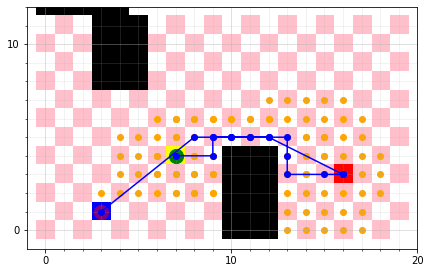

<Figure size 432x288 with 0 Axes>

In [262]:
#-----Pour voir les résultats de la vision etc----
occupancy_grid, list_paintings_grid, start_grid, goal_grid, fig, ax= create_fill_grid()
occupancy_grid = checkerboard(occupancy_grid)
path = thymio_path(list_paintings_grid, start_grid, goal_grid, fig, ax, occupancy_grid)

start_cm = convert_grid_to_cm(start_grid[0],start_grid[1])
Pablo = T(start_cm[0], start_cm[1])



In [263]:
print(path)

[[7, 4], [9, 4], [9, 5], [10, 5], [11, 5], [12, 5], [16, 3], [16, 3], [16, 3], [15, 3], [13, 3], [13, 4], [13, 5], [12, 5], [11, 5], [10, 5], [9, 5], [8, 5], [3, 1]]


 `get_local_mode(local_mode)` is a function that will check if we're in a situation where we need to avoid obstacles (so then enter obstacle avoidance mode) or not

In [264]:
def get_local_mode(local_mode):
    Threshold_enter_obstavoid =20 
    Threshold_quit_obstavoid =10
    
    if (local_mode == 0 and
            (th["prox.horizontal"][0] > Threshold_enter_obstavoid or
            th["prox.horizontal"][1] > Threshold_enter_obstavoid or
            th["prox.horizontal"][2] > Threshold_enter_obstavoid or
            th["prox.horizontal"][3] > Threshold_enter_obstavoid or
            th["prox.horizontal"][4] > Threshold_enter_obstavoid)): # enter obstacle avoidance
            local_mode = 1
    elif (local_mode == 1 and
            th["prox.horizontal"][0] < Threshold_quit_obstavoid and
            th["prox.horizontal"][1] < Threshold_enter_obstavoid and
            th["prox.horizontal"][2] < Threshold_enter_obstavoid and
            th["prox.horizontal"][3] < Threshold_enter_obstavoid and
            th["prox.horizontal"][4] < Threshold_quit_obstavoid): # quit obstacle avoidance
            local_mode = 0
    return local_mode

In [265]:
def local_obstacle_avoidance(occupancy_grid):
    local_mode = 1
    speed = 50
    neg_speed = 2**16 - 50
    
    while local_mode:
        pos = particules.believe(Pablo, occupancy_grid)
        Pablo.set_pos(pos[0], pos[1], pos[2])
        th.set_var("motor.left.target", speed)
        th.set_var("motor.right.target", neg_speed)
        Pablo.set_vel([speed,-speed])
        local_mode = get_local_mode(local_mode)

In [269]:
def navigation (path, visited_painting):
    global particules

    time0 = time.time()
    threshold_angle = 0.5 #1 #degree
    threshold_dist = 1 #cm
    local_mode = 0
    counter =0
    
    while path:
        curr_goal = convert_grid_to_cm(path[0][0],path[0][1]) #next step
        remaining_theta = angle(Pablo.theta, Pablo.x, Pablo.y, curr_goal[0], curr_goal[1])
        rotating = rotate_pablo(remaining_theta, threshold_angle, occupancy_grid)
        time_prec = time.time()

        while rotating:
            remaining_theta = angle(Pablo.theta, Pablo.x, Pablo.y, curr_goal[0], curr_goal[1])
            rotating = rotate_pablo(remaining_theta, threshold_angle, occupancy_grid)
            time_next = time.time()
            duration = time_next - time_prec
            time_prec = time_next

            #get the mode : 1 if local obstacle avoidance
            local_mode = get_local_mode(local_mode)
            if local_mode:
                counter = 0
                time_before = time.time()
                local_obstacle_avoidance(occupancy_grid)
                time_after = time.time()
                duration_local = time_after - time_before
                time_null = time.time()
                while counter <= 1.5:
                    move_straight = 1
                    move_straight = move_pablo(10, threshold_dist, occupancy_grid)
                    counter = time.time() - time_null
                stop_pablo(occupancy_grid)
                remaining_theta = angle(Pablo.theta, Pablo.x, Pablo.y, curr_goal[0], curr_goal[1])
                goal_reached = False
                return goal_reached, visited_painting
                
        remaining_distance = distance(Pablo.x, Pablo.y, curr_goal[0], curr_goal[1])
        move_straight = move_pablo(remaining_distance, threshold_dist, occupancy_grid)
        time_prec = time.time()
        while move_straight:
            remaining_theta = angle(Pablo.theta, Pablo.x, Pablo.y, curr_goal[0], curr_goal[1])
            if remaining_theta >= threshold_angle:
                break
            remaining_distance = distance(Pablo.x, Pablo.y, curr_goal[0], curr_goal[1])
            move_straight = move_pablo(remaining_distance, threshold_dist, occupancy_grid)
            time_next = time.time()
            duration = time_next - time_prec
            time_prec = time_next

            #get the mode : 1 if local obstacle avoidance
            local_mode = get_local_mode(local_mode)
            if local_mode:
                counter = 0
                time_before = time.time()
                local_obstacle_avoidance(occupancy_grid)
                time_after = time.time()
                duration_local = time_after - time_before
                time_null = time.time()
                while counter <= 1.5:
                    move_straight = 1
                    move_straight = move_pablo(10, threshold_dist, occupancy_grid)
                    counter = time.time() - time_null
                move_straight = 0
                stop_pablo(occupancy_grid)
                remaining_distance = distance(Pablo.x, Pablo.y, curr_goal[0], curr_goal[1])
                goal_reached = False
                return goal_reached, visited_painting
            
        threshold_dist = threshold_dist + 0.05 #cm
        print('fini de move', remaining_distance)
        stop_pablo(occupancy_grid)
        
        #delete path coordinates that are consecutively the same
        if len(path)>=2:
            while path[1] == path[0]:
                del path[1]
                
        if ((abs(Pablo.x - curr_goal[0]) <= threshold_dist) and (abs(Pablo.y - curr_goal[1]) <= threshold_dist)):
            if occupancy_grid[path[0][0]][path[0][1]] == painting_here:
                visited_painting = True
            del path[0]
    goal_reached = True
    return goal_reached, visited_painting
        
    

# -------------------------------------------------MAIN----------------------------------------------------

------------path : [[9, 4], [9, 5], [10, 5], [11, 5], [12, 5], [16, 3], [16, 3], [16, 3], [15, 3], [13, 3], [13, 4], [13, 5], [12, 5], [11, 5], [10, 5], [9, 5], [8, 5], [3, 1]]
----------------------------current goal : [9, 4]
POS X Y 45 27
 --Rotating--Pablo [x, y, theta] : 44.96398312567817 26.944153564080015 88.75755385930479
 --Rotating--Pablo [x, y, theta] : 44.9521184566201 26.97234551246509 87.7362196441438
 --Rotating--Pablo [x, y, theta] : 44.945499076484275 26.96514113861457 86.49612577630448
 --Rotating--Pablo [x, y, theta] : 44.979203706566885 26.98075027988059 85.30777472309175
 --Rotating--Pablo [x, y, theta] : 44.98276010533247 26.98180725462467 84.08364782894651
 --Rotating--Pablo [x, y, theta] : 44.98205860355735 26.976124646334405 82.90634660381384
 --Rotating--Pablo [x, y, theta] : 44.96622568106247 26.97825368195364 81.68474203768223
 --Rotating--Pablo [x, y, theta] : 44.95690891658717 26.969997250748833 80.45460372907755
 --Rotating--Pablo [x, y, theta] : 44.960035

----move streaight---Pablo [x, y, theta] : 54.897224247591666 27.198381562894603 1.4225682023322457
remaining dist, curr_goal : 2.2816025155591975 (57, 27)
----move streaight---Pablo [x, y, theta] : 55.08631029719214 27.21108038175153 1.4250890106996446
remaining dist, curr_goal : 2.1121129490188117 (57, 27)
----move streaight---Pablo [x, y, theta] : 55.28489581991357 27.222681622246608 1.4296465634645386
remaining dist, curr_goal : 1.9252956152739764 (57, 27)
----move streaight---Pablo [x, y, theta] : 55.45769800611146 27.204905774613408 1.425156603929922
remaining dist, curr_goal : 1.7294997697127104 (57, 27)
----move streaight---Pablo [x, y, theta] : 55.64056726755342 27.21269491909579 1.424130903630847
remaining dist, curr_goal : 1.555854047403707 (57, 27)
----move streaight---Pablo [x, y, theta] : 55.81246308160887 27.21179115442838 1.4259609101067028
remaining dist, curr_goal : 1.3759711053130197 (57, 27)
----move streaight---Pablo [x, y, theta] : 55.982931726182905 27.2242859598

 --Rotating--Pablo [x, y, theta] : 56.19615169178958 32.60497284984632 55.14195587733412
 --Rotating--Pablo [x, y, theta] : 56.14806829501231 32.59568421421231 54.05038725430889
 --Rotating--Pablo [x, y, theta] : 56.199081932957014 32.61191897852282 52.86018158506548
 --Rotating--Pablo [x, y, theta] : 56.20061499550299 32.6042007374496 51.72337869550552
 --Rotating--Pablo [x, y, theta] : 56.19295571610249 32.599077017581706 50.62384950267416
 --Rotating--Pablo [x, y, theta] : 56.20333723600999 32.602064211454255 49.552867370015505
 --Rotating--Pablo [x, y, theta] : 56.21681722352146 32.57356696942098 48.42435229119149
 --Rotating--Pablo [x, y, theta] : 56.20308886560257 32.561557612620646 47.37850633358909
 --Rotating--Pablo [x, y, theta] : 56.174778159686085 32.59465218553322 46.21285934338182
 --Rotating--Pablo [x, y, theta] : 56.19399483616276 32.62470964934485 45.12093450490016
 --Rotating--Pablo [x, y, theta] : 56.21241813741035 32.62327124318436 43.96686793956094
 --Rotating--Pab

 --Rotating--Pablo [x, y, theta] : 68.15897609553757 33.068164835315955 -0.2707070053008859
fini de rotating -0.3001765618577652
----move streaight---Pablo [x, y, theta] : 68.28178959278104 33.06802124065562 0.9097294441786206
remaining dist, curr_goal : 6.871098023943393 (75, 33)
----move streaight---Pablo [x, y, theta] : 68.40244751594528 33.05360527858928 0.9276258823889973
remaining dist, curr_goal : 6.718554752686436 (75, 33)
----move streaight---Pablo [x, y, theta] : 68.60283879875504 33.06317428625353 0.9179648891199703
remaining dist, curr_goal : 6.59777025257391 (75, 33)
----move streaight---Pablo [x, y, theta] : 68.77066462543083 33.071984209494275 0.914215374223196
remaining dist, curr_goal : 6.397473128130938 (75, 33)
----move streaight---Pablo [x, y, theta] : 68.95116834273924 33.092629670488336 0.9205147607667599
remaining dist, curr_goal : 6.229751273949498 (75, 33)
----move streaight---Pablo [x, y, theta] : 69.13124853197291 33.08723043672889 0.9240379464915611
remainin

----move streaight---Pablo [x, y, theta] : 82.94594204953286 29.00115467825662 -24.567168872724398
remaining dist, curr_goal : 18.114443858311528 (99, 21)
----move streaight---Pablo [x, y, theta] : 83.10818091705627 28.905780017963227 -24.56782522310047
remaining dist, curr_goal : 17.937426037822288 (99, 21)
----move streaight---Pablo [x, y, theta] : 83.2706989513091 28.831895102678125 -24.569886859284217
remaining dist, curr_goal : 17.749683700208323 (99, 21)
----move streaight---Pablo [x, y, theta] : 83.37087544806505 28.71284663492273 -24.588459151654817
remaining dist, curr_goal : 17.571268946200277 (99, 21)
----move streaight---Pablo [x, y, theta] : 83.53480058788007 28.64461392523441 -24.599361908618903
remaining dist, curr_goal : 17.42864129740855 (99, 21)
----move streaight---Pablo [x, y, theta] : 83.6792314812212 28.602212230908812 -24.59326989549986
remaining dist, curr_goal : 17.251449646986842 (99, 21)
----move streaight---Pablo [x, y, theta] : 83.80915553058928 28.48474539

 --Rotating--Pablo [x, y, theta] : 98.22419486263209 21.82879876513025 -39.77978250199702
 --Rotating--Pablo [x, y, theta] : 98.20137119941742 21.806498916002774 -41.19007573577953
 --Rotating--Pablo [x, y, theta] : 98.2080697207208 21.839936061253173 -42.32586414080808
 --Rotating--Pablo [x, y, theta] : 98.21244809052472 21.81454583472397 -43.414558630000016
 --Rotating--Pablo [x, y, theta] : 98.21630889923935 21.793012025403293 -44.54431552225718
 --Rotating--Pablo [x, y, theta] : 98.21369957754627 21.80314510840906 -45.6318549506388
 --Rotating--Pablo [x, y, theta] : 98.16417257093295 21.81078068022795 -46.79873816089498
 --Rotating--Pablo [x, y, theta] : 98.21147200766481 21.814938654173847 -47.90092344522047
 --Rotating--Pablo [x, y, theta] : 98.18944421122208 21.818691218491757 -49.02177917022658
 --Rotating--Pablo [x, y, theta] : 98.19533696844765 21.810118324343946 -50.13070171907787
 --Rotating--Pablo [x, y, theta] : 98.19164627943387 21.81902248204728 -51.15920263827494
 --Ro

remaining dist, curr_goal : 12.827865119875753 (81, 21)
----move streaight---Pablo [x, y, theta] : 93.51275717882761 21.124456057587118 -177.55557497568947
remaining dist, curr_goal : 12.662930570778709 (81, 21)
----move streaight---Pablo [x, y, theta] : 93.32880463781518 21.12805628832658 -177.5600293264102
remaining dist, curr_goal : 12.513376104256281 (81, 21)
----move streaight---Pablo [x, y, theta] : 93.14166679271858 21.09018370486201 -177.56050655551653
remaining dist, curr_goal : 12.329469664604115 (81, 21)
----move streaight---Pablo [x, y, theta] : 92.94406221677772 21.102570841826328 -177.55977004577667
remaining dist, curr_goal : 12.142001713310197 (81, 21)
----move streaight---Pablo [x, y, theta] : 92.80670684250494 21.066692082644966 -177.56195308625712
remaining dist, curr_goal : 11.944502627395172 (81, 21)
----move streaight---Pablo [x, y, theta] : 92.62294833746273 21.04145891635866 -177.56453159001782
remaining dist, curr_goal : 11.80689520148038 (81, 21)
----move stre

 --Rotating--Pablo [x, y, theta] : 82.32017126626118 20.532457868518904 -98.10104362222975
 --Rotating--Pablo [x, y, theta] : 82.36506285620152 20.564568728663282 -97.02648533778833
 --Rotating--Pablo [x, y, theta] : 82.33445692309894 20.540593964995253 -95.86903021398436
 --Rotating--Pablo [x, y, theta] : 82.36400246834823 20.54180354340163 -94.74083300734824
 --Rotating--Pablo [x, y, theta] : 82.32228732640266 20.55088904389114 -93.5529590283358
 --Rotating--Pablo [x, y, theta] : 82.33407251598214 20.533395125651943 -92.5047813258626
 --Rotating--Pablo [x, y, theta] : 82.35639615383639 20.52576181313939 -91.31797952248041
 --Rotating--Pablo [x, y, theta] : 82.32750986260663 20.506467756842433 -90.18893409861383
 --Rotating--Pablo [x, y, theta] : 82.33323980305875 20.488292902821723 -89.02702312656137
 --Rotating--Pablo [x, y, theta] : 82.33281374416744 20.515602048058412 -87.84398590936814
 --Rotating--Pablo [x, y, theta] : 82.34613899223514 20.515784920876627 -86.70839883381814
 --R

KeyboardInterrupt: 

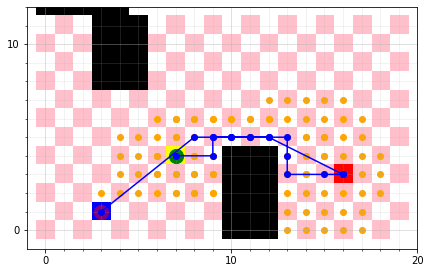

<Figure size 432x288 with 0 Axes>

In [276]:
goal_reached = False
visited_painting = False

occupancy_grid, list_paintings_grid, start_grid, goal_grid, fig, ax= create_fill_grid()
occupancy_grid = checkerboard(occupancy_grid)

#start position given to Pablo so we can delete it in the path
start_cm = convert_grid_to_cm(int(start_grid[0]),int(start_grid[1]))
Pablo = T(start_cm[0], start_cm[1])

M = 500
global particules
particules = ParticlesF(M, Pablo, time.time())


while not goal_reached:
    

    start_grid = convert_cm_to_grid(Pablo.x, Pablo.y)
    #if the painting is already visited, don't go there again
    if visited_painting == True:
        list_paintings_grid = []
        
    path = thymio_path(list_paintings_grid, start_grid, goal_grid, fig, ax, occupancy_grid)
    del path[0] 
    goal_reached, visited_painting = navigation(path, visited_painting)
    
stop_pablo(occupancy_grid)


In [277]:
th.set_var("motor.left.target", 0)
th.set_var("motor.right.target", 0)

In [39]:
stop_pablo(occupancy_grid)

TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [ ]:
print(Pablo.x, Pablo.y)
print(occupancy_grid)
print(occupancy_grid[9][4])
print('start', start_grid)

In [ ]:
t = time.time()
t_next = t + 9.04
while time.time()<t_next:
    th.set_var("motor.left.target", 100)
    th.set_var("motor.right.target", 2**16 -100)
    
th.set_var("motor.right.target", 0)
th.set_var("motor.left.target", 0)

In [ ]:
t = time.time()
t_next = t + 9.52
while time.time()<t_next:
    th.set_var("motor.right.target", 100)
    th.set_var("motor.left.target", 2**16 -100)
    
th.set_var("motor.right.target", 0)
th.set_var("motor.left.target", 0)

In [ ]:
t = time.time() #5.8cm ->1.8s
t_next = t + 1.8
while time.time()<t_next:
    th.set_var("motor.right.target", 100)
    th.set_var("motor.left.target", 100)
    
th.set_var("motor.right.target", 0)
th.set_var("motor.left.target", 0)